## Download package, and scale data using svm_scale

In [1]:
# (1)


from libsvm import svmutil
import numpy as np
import pandas as pd
import sys
import os 
import csv
from subprocess import *

# (2)

fn = "abalone.data"
colnames = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
    'Rings'
    ]
df = pd.read_csv(fn,sep=",",header=None, names = colnames)

df["label"] = (df["Rings"] > 9)*1 + (df["Rings"]<=9)*-1
df = pd.concat([df,pd.get_dummies(df["Sex"])],axis=1)


def row_fmt(r):
    sb = ""
    for i in range(1,len(r)):
        sb += " {index}:{value}".format(index=i,value=r.iloc[i])
    return "{label}{sb}".format(label=int(r["label"]),sb=sb)

tmp = df[["label","F","I","M",'Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']]
df_out = tmp.apply(func=row_fmt,axis=1)

df_out.to_csv("df_all",header=False,index=False, quoting=csv.QUOTE_NONE)
df_out.iloc[0:3133].to_csv("df_train",header=False,index=False, quoting=csv.QUOTE_NONE)
df_out.iloc[3133:].to_csv("df_test",header=False,index=False, quoting=csv.QUOTE_NONE)


svmscale_exe = r".\libsvm-3.25\windows\svm-scale.exe"
svmtrain_exe = r".\libsvm-3.25\windows\svm-train.exe"
svmpredict_exe = r".\libsvm-3.25\windows\svm-predict.exe"
assert os.path.exists(svmscale_exe),"svm-scale executable not found"
assert os.path.exists(svmtrain_exe),"svm-train executable not found"
assert os.path.exists(svmpredict_exe),"svm-predict executable not found"

def my_scale(fn):
    assert os.path.exists(fn),"training file not found"
    scaled_file = fn + "_scale"
    range_file = fn + "_range"
    
    cmd = '{0} -s "{1}" "{2}" > "{3}"'.format(svmscale_exe, range_file, fn, scaled_file)
    print('Scaling {fn}...'.format(fn=fn))
    Popen(cmd, shell = True, stdout = PIPE).communicate()
    return

my_scale("df_train")
my_scale("df_test")

Scaling df_train...
Scaling df_test...


## Load the scaled dataset and perform 5-fold cross validation


In [2]:
# (3)

def my_parse_txt(fn,colnames):
    ncol = len(colnames)
    df = pd.read_csv(fn,sep="\t",header=None,index_col=False,names=range(ncol))
    str_lst = [x.split() for x in df[0]]
    dct_lst = []
    for s1 in str_lst:
        dct = {}
        for s2 in s1:
            if ":" in s2:
                tmp = s2.split(":")
                dct[tmp[0]] = float(tmp[1])
            else:
                dct["label"] = int(s2)
        dct_lst.append(dct)
    df = pd.DataFrame.from_records(dct_lst)
    df.columns = colnames
    return df.fillna(0)



fn = "df_train_scale"
colnames = ["label","F","I","M",'Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight']

df_train_scaled = my_parse_txt("df_train_scale",colnames)
df_test_scaled =  my_parse_txt("df_test_scale",colnames)



In [3]:

def my_cv(df,nfold,c,d):
    cv_res = []
    fold = df.index % nfold
    for i in range(nfold):
        val = df.loc[fold==i]
        dev = df.loc[fold!=i]
        sol = svmutil.svm_train(
            np.array(dev.iloc[:,0]),
            np.array(dev.iloc[:,1:]),
            '-c {C} -t 1 -d {D}'.format(C=c,D=d)
            )
        pred = svmutil.svm_predict(
            np.array(val.iloc[:,0]),
            np.array(val.iloc[:,1:]),
            sol)
        cv_res.append((pred[1],sol.nSV.contents.value))
    return cv_res 

cv_grid_res = []
for d in range(1,6):
    cv_fix_d = []
    for k in range(-10,10):
        cv_res = my_cv(df_train_scaled,5,3**k,d)
        cv_fix_d.append(cv_res)
    cv_grid_res.append(cv_fix_d)
    

cv_grid_stat = []
cv_grid_nsv = []
for r in cv_grid_res:
    cv_stat_row = []
    cv_nsv_row = []
    for c in r:
        mu = sig = 0
        for cv in c:
            (acc, _, _), nsv = cv
            err = 1 - acc/100
            mu += err
            sig += err**2
        mu /= len(c)
        sig = (sig/(len(c)-1) - mu**2*len(c)/(len(c)-1)) ** 0.5
        cv_stat_row.append([mu-sig,mu,mu+sig])
        cv_nsv_row.append(nsv)
    cv_grid_stat.append(cv_stat_row)
    cv_grid_nsv.append(cv_nsv_row)
    
cv_grid_stat = pd.DataFrame(cv_grid_stat,index=range(1,6),columns=range(-10,10))
cv_grid_nsv = pd.DataFrame(cv_grid_nsv,index=range(1,6),columns=range(-10,10))



Accuracy = 49.2823% (309/627) (classification)
Accuracy = 51.0367% (320/627) (classification)
Accuracy = 52.4721% (329/627) (classification)
Accuracy = 51.278% (321/626) (classification)
Accuracy = 50.9585% (319/626) (classification)
Accuracy = 49.2823% (309/627) (classification)
Accuracy = 51.0367% (320/627) (classification)
Accuracy = 52.4721% (329/627) (classification)
Accuracy = 51.278% (321/626) (classification)
Accuracy = 50.9585% (319/626) (classification)
Accuracy = 49.2823% (309/627) (classification)
Accuracy = 51.0367% (320/627) (classification)
Accuracy = 52.4721% (329/627) (classification)
Accuracy = 51.278% (321/626) (classification)
Accuracy = 50.9585% (319/626) (classification)
Accuracy = 49.2823% (309/627) (classification)
Accuracy = 51.0367% (320/627) (classification)
Accuracy = 52.4721% (329/627) (classification)
Accuracy = 51.278% (321/626) (classification)
Accuracy = 50.9585% (319/626) (classification)
Accuracy = 49.2823% (309/627) (classification)
Accuracy = 51.036

Accuracy = 80.8612% (507/627) (classification)
Accuracy = 79.1069% (496/627) (classification)
Accuracy = 79.9043% (501/627) (classification)
Accuracy = 82.4281% (516/626) (classification)
Accuracy = 80.5112% (504/626) (classification)
Accuracy = 80.5423% (505/627) (classification)
Accuracy = 79.5853% (499/627) (classification)
Accuracy = 79.7448% (500/627) (classification)
Accuracy = 82.2684% (515/626) (classification)
Accuracy = 80.5112% (504/626) (classification)
Accuracy = 80.5423% (505/627) (classification)
Accuracy = 78.9474% (495/627) (classification)
Accuracy = 79.5853% (499/627) (classification)
Accuracy = 82.2684% (515/626) (classification)
Accuracy = 80.9904% (507/626) (classification)
Accuracy = 80.7018% (506/627) (classification)
Accuracy = 78.9474% (495/627) (classification)
Accuracy = 79.9043% (501/627) (classification)
Accuracy = 81.7891% (512/626) (classification)
Accuracy = 80.8307% (506/626) (classification)
Accuracy = 80.3828% (504/627) (classification)
Accuracy = 78

Accuracy = 71.4514% (448/627) (classification)
Accuracy = 74.1627% (465/627) (classification)
Accuracy = 74.1214% (464/626) (classification)
Accuracy = 73.6422% (461/626) (classification)
Accuracy = 73.2057% (459/627) (classification)
Accuracy = 72.0893% (452/627) (classification)
Accuracy = 76.0766% (477/627) (classification)
Accuracy = 74.9201% (469/626) (classification)
Accuracy = 73.3227% (459/626) (classification)
Accuracy = 74.8006% (469/627) (classification)
Accuracy = 74.8006% (469/627) (classification)
Accuracy = 76.555% (480/627) (classification)
Accuracy = 76.0383% (476/626) (classification)
Accuracy = 76.5176% (479/626) (classification)
Accuracy = 76.3955% (479/627) (classification)
Accuracy = 77.3525% (485/627) (classification)
Accuracy = 79.1069% (496/627) (classification)
Accuracy = 79.2332% (496/626) (classification)
Accuracy = 78.115% (489/626) (classification)
Accuracy = 77.9904% (489/627) (classification)
Accuracy = 78.7879% (494/627) (classification)
Accuracy = 80.0

## Plot CV results - average error +- 1 std bands


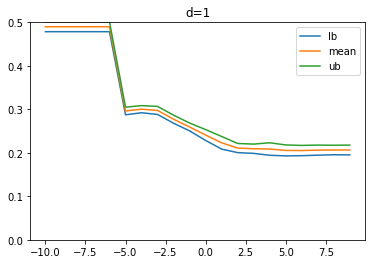

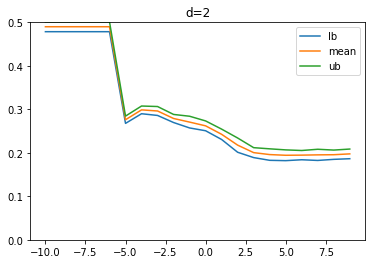

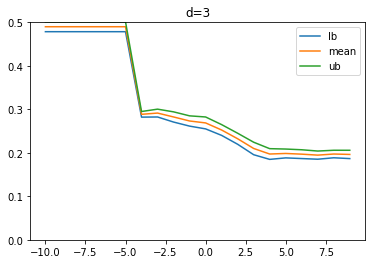

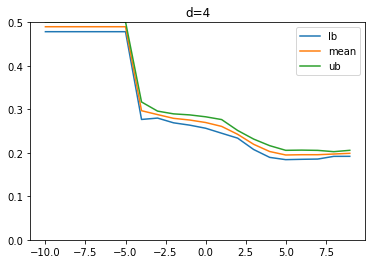

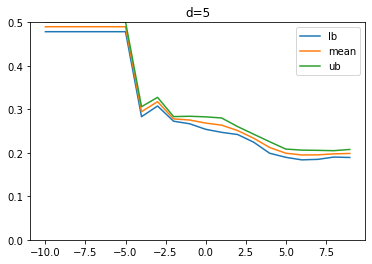

In [5]:
def my_cv_plot_fix_d(d,cv_grid_stat):
    i = d-1
    df = pd.DataFrame()
    df["lb"] = cv_grid_stat.iloc[i,:].apply(lambda s: s[0])
    df["mean"] = cv_grid_stat.iloc[i,:].apply(lambda s: s[1])
    df["ub"] = cv_grid_stat.iloc[i,:].apply(lambda s: s[2])
    df.plot(ylim=(0,0.5),title="d={d}".format(d=d))
    return df


def my_cv_plot_fix_c(k,cv_grid_stat):
    i = k+10
    df = pd.DataFrame()
    df["lb"] = cv_grid_stat.iloc[:,i].apply(lambda s: s[0])
    df["mean"] = cv_grid_stat.iloc[:,i].apply(lambda s: s[1])
    df["ub"] = cv_grid_stat.iloc[:,i].apply(lambda s: s[2])
    df.plot(ylim=(0,0.5),title="C={c}".format(c=3**k))
    return df

for d in range(1,6):
    my_cv_plot_fix_d(d,cv_grid_stat)

## Find optimal pair of C* d*

In [6]:
min_err = 1<<32
min_r, min_c = -1,-1
for r in range(cv_grid_stat.shape[0]):
    for c in range(cv_grid_stat.shape[1]):
        if (min_err > cv_grid_stat.iloc[r,c][1]):
            min_r, min_c = r,c
            min_err = cv_grid_stat.iloc[r,c][1]
        
min_err 
3**(min_c-10), min_r+1   # best C,d for average CV error are (243,2)

(243, 2)

For the remainder of the problem, i use d=1 and C=243. There does not seem to be significant improvement in CV error when increasing the complexity of the kernel. 

## CV error and Test error. Number of support vectors. 

Accuracy = 78.4483% (819/1044) (classification)
Accuracy = 62.931% (657/1044) (classification)
Accuracy = 56.6092% (591/1044) (classification)
Accuracy = 64.272% (671/1044) (classification)
Accuracy = 67.2414% (702/1044) (classification)


<AxesSubplot:>

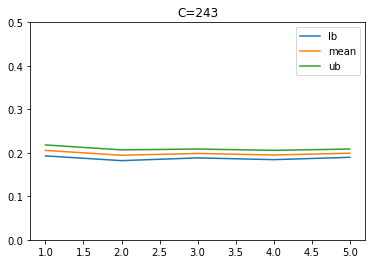

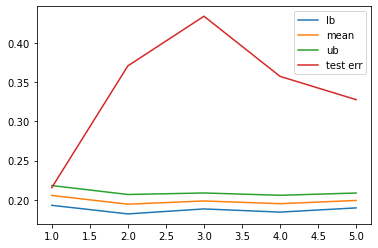

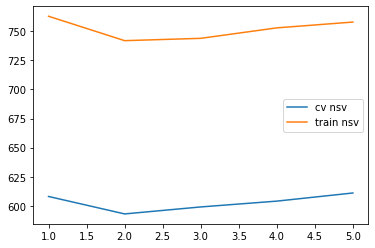

In [7]:
# (4)
k=5
test_res = []
df = my_cv_plot_fix_c(k,cv_grid_stat)
df["cv nsv"] = cv_grid_nsv.iloc[:,k+10]

for d in range(1,6):
    sol = svmutil.svm_train(
        np.array(df_train_scaled.iloc[:,0]),
        np.array(df_train_scaled.iloc[:,1:]),
        '-c {C} -t 1 -d {D}'.format(C=3**k,D=d)
        )
    pred = svmutil.svm_predict(
        np.array(df_test_scaled.iloc[:,0]),
        np.array(df_test_scaled.iloc[:,1:]),
        sol)
    test_res.append((1-pred[1][0]/100,sol.nSV.contents.value))
    
df["test err"] = [x[0] for x in test_res]
df["train nsv"] = [x[1] for x in test_res]

df[["lb","mean","ub","test err"]].plot()
df[["cv nsv","train nsv"]].plot()

# nSV nBSV  maginSV
# 1526 1516 10
# 1480 1456 24
# 1483 1447 36
# 1497 1450 47
# 1517 1473 44

# This last part is done using Cygwin. The number of SV on the margin is nSV - nBSV. 

Accuracy = 69.3487% (724/1044) (classification)
Accuracy = 66.092% (690/1044) (classification)
Accuracy = 58.6207% (612/1044) (classification)
Accuracy = 60.3448% (630/1044) (classification)
Accuracy = 56.705% (592/1044) (classification)
Accuracy = 53.9272% (563/1044) (classification)
Accuracy = 54.7893% (572/1044) (classification)
Accuracy = 57.7586% (603/1044) (classification)
Accuracy = 56.6092% (591/1044) (classification)
Accuracy = 54.7893% (572/1044) (classification)
Accuracy = 54.4061% (568/1044) (classification)
Accuracy = 53.2567% (556/1044) (classification)
Accuracy = 53.2567% (556/1044) (classification)
Accuracy = 53.2567% (556/1044) (classification)
Accuracy = 52.9693% (553/1044) (classification)
Accuracy = 52.682% (550/1044) (classification)
Accuracy = 58.2375% (608/1044) (classification)
Accuracy = 63.9847% (668/1044) (classification)
Accuracy = 65.7088% (686/1044) (classification)
Accuracy = 73.8506% (771/1044) (classification)
Accuracy = 77.7778% (812/1044) (classificat

<AxesSubplot:title={'center':'test error'}>

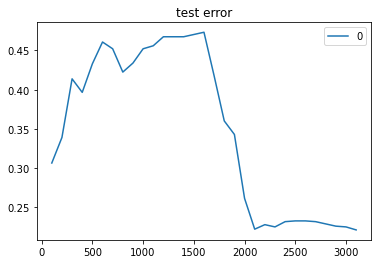

In [8]:
# (5)
d = 1
c = 3**5
test_res = []
for i in range(100,df_train_scaled.shape[0],100):
    sol = svmutil.svm_train(
        np.array(df_train_scaled.iloc[:i,0]),
        np.array(df_train_scaled.iloc[:i,1:]),
        '-c {C} -t 1 -d {D}'.format(C=c,D=d)
        )
    pred = svmutil.svm_predict(
        np.array(df_test_scaled.iloc[:,0]),
        np.array(df_test_scaled.iloc[:,1:]),
        sol)
    test_res.append((1-pred[1][0]/100))
pd.DataFrame(test_res, index=range(100,df_train_scaled.shape[0],100)).plot(title="test error")





## SGD

Based on 6.a, 6.b, we can perform learning similarly as above. 

In [9]:
# (6.c)

def K(x,x_prime,d):
    return (sum(x * x_prime + 1) )**d

df_all = my_parse_txt("df_all",colnames)
y = df_all.iloc[:,0]
X = df_all.iloc[:,1:]
ksi = [[0] * X.shape[1] for _ in range(X.shape[0])]
for i in range(X.shape[0]):
    ksi_i = [0]*X.shape[1]
    for j in range(X.shape[1]):
        ksi_i[j] = y.iloc[j]*K(X.iloc[i,:],X.iloc[j,:],d)
    ksi[i] = ksi_i
ksi = np.array(ksi)

